# Names (Enter your names below)
**Your Name and JHED:** ...
Sean Darcy, sdarcy2
**Partner's Name and JHED (If applicable):**  ...

# Lab 1: Heart Rate Estimation and Signal De-noising
By **Benjamín Béjar Haro** and edited by **Kwame Kutten**

In this lab we will address the problem of heart rate estimation from noisy observations. For a healthy individual, and under ideal conditions, this task might be easy to accomplish. However, different disorders together with different sources of error cause distortions to the signal rendering the estimation task more difficult. We will study how prior information about the signal and the interference can be exploited in order to improve the estimation task under less ideal conditions.

We will start detecting the QRS-complex assuming we have a template of the underlying waveform. Later, we will move to a more realistic scenario where we will be implementing a simplified version of the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Task 1. Signal generation and template matching (40 points total)
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Task 1A: Signal Generation (15 points) -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $K = 10$ equally spaced pulses over a time span of $10\ s$.  Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


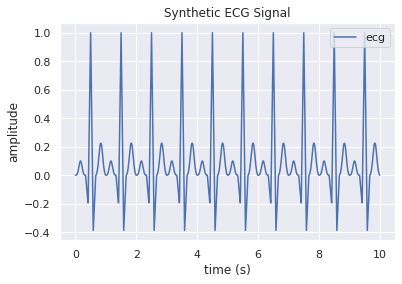

In [144]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Write Your code here
# ============================================================================

x = np.linspace(0,1, 256, endpoint=False)
ecg = ecg_wave(x)


for i in range(0, 9) :
  ecg = np.concatenate([ecg, ecg_wave(x)])



#sig = np.convolve(ecg, function)
time = np.linspace(0, 10, 2560)

plt.figure()
plt.plot(time, ecg)
plt.title('Synthetic ECG Signal')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(['ecg'])



* **Task 1B: Simulate Noise (5 points)-** Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations.

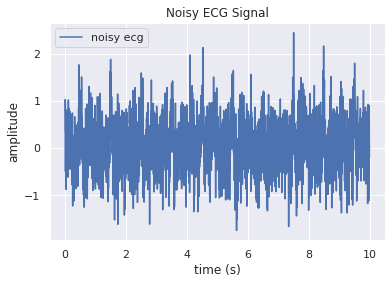

In [243]:
# ============================================================================
# Write Your code here
# ============================================================================

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


# generate noise
n = .5*np.random.randn(2560)
    
# return noisy signal
noisySignal = ecg+n

plt.figure()
plt.plot(time, noisySignal)
plt.title('Noisy ECG Signal')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(['noisy ecg'])


* **Task 1C: Find Peaks (10 points) -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate`.   We recommend that you normalize the signal to range $[0,1]$ using `noralize_range` before thresholding. Then plot the result. Next choose a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function with the `height` parameter set to the your chosen threshold.  Print the times of each peak in seconds.

Peak at t = 0.4921875 seconds
Peak at t = 1.5 seconds
Peak at t = 2.49609375 seconds
Peak at t = 3.50390625 seconds
Peak at t = 4.49609375 seconds
Peak at t = 5.49609375 seconds
Peak at t = 6.4921875 seconds
Peak at t = 7.5 seconds
Peak at t = 8.4921875 seconds
Peak at t = 9.49609375 seconds


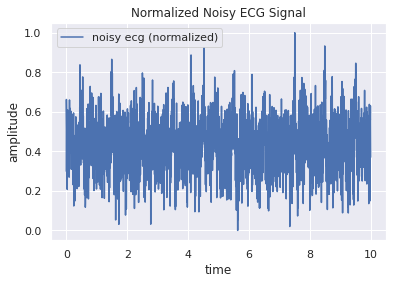

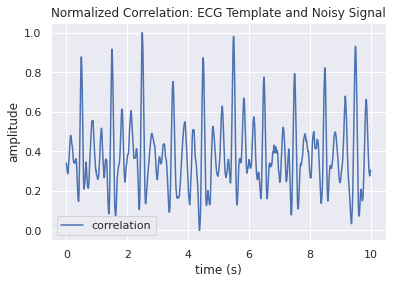

In [244]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# ============================================================================
# Write Your code here
# ============================================================================


correlateOutput = np.correlate(ecg_template, noisySignal, mode = 'same')
normalizedNoisy = normalize_range(noisySignal)
normCorrelateOutput = normalize_range(correlateOutput)
plt.figure()
plt.plot(time, normalizedNoisy)
plt.title('Normalized Noisy ECG Signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend(['noisy ecg (normalized)'])
plt.figure()
plt.plot(time, normCorrelateOutput)
plt.title('Normalized Correlation: ECG Template and Noisy Signal')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(['correlation'])

thresholdValue = 0.69
thresholdingOut = signal.find_peaks(normCorrelateOutput, height = thresholdValue)
nmSuppression = thresholdingOut[0] * 10/len(normCorrelateOutput)

for times in nmSuppression :
  print("Peak at t =", times, "seconds")


* **Task 1D: RR Intervals (10 Points)** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number intervals between peaks. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


The average RR interval is 1.0004340277777777 seconds
The eastimated heart rate is 59.97396963123645 beats per minute


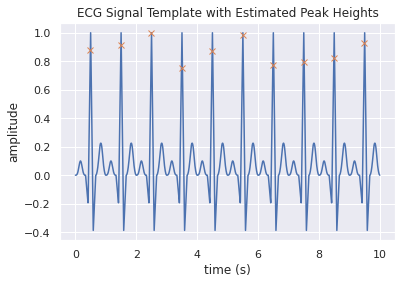

In [245]:
# ============================================================================
# Write your code here
# ============================================================================

plt.figure()
plt.plot(time, ecg)
plt.plot(nmSuppression, thresholdingOut[1]['peak_heights'], 'x')
plt.title('ECG Signal Template with Estimated Peak Heights')
plt.xlabel('time (s)')
plt.ylabel('amplitude')

N = len(nmSuppression)
R = 0

for i in range(1, N) :
  R = R + (nmSuppression[i] - nmSuppression[i - 1])

R = R / (N - 1)

heartRate = 60 / R

print("The average RR interval is", R, "seconds" )
print("The eastimated heart rate is", heartRate, "beats per minute" )


### Task 2. QRS complex detection via Pan-Tompkins algorithm (60 points total)
Now let us consider a more realistic scenario where we have a noisy ECG signal and the waveform of the QRS-complex is unknown. There are different sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy  individual where signal distortion comes solely from the acquisition process. The procedure that we will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

**Important Note 1:** You may need to **adjust the `path` variable below.**

**Important Note 2:** If you are using **Google Colab you must follow these steps**

1. Upload **ecg_mitnst.json** into your Google Drive.  If you placed it in a sub folder called **lab1** the use `path = "gdrive/My Drive/lab1/"`. Otherwise use `path = "gdrive/My Drive/"`
2. Run the folloing cell and follow instructions to obtain the authorization key

In [132]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================


try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = 'gdrive/My Drive/ecg_mitnst.json' # Change path to location of data
except:
    # Executes if running locally (e.g. Anaconda)
    path = 'ecg_mitnst.json' # Change path to location of data

with open(path,'r') as infile: data = json.load(infile)

# print data to see dictionary fields
print(data.keys())

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


**Task 2A: Effect of noise (10 points):** Load the signal **ecg_mitnst.json**  You may have to change `path` to point to the correct loation where you downloaded **ecg_mitnst.json**. The loaded `data` dictionary will contain four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks.  Plot the voltage over time with the given peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

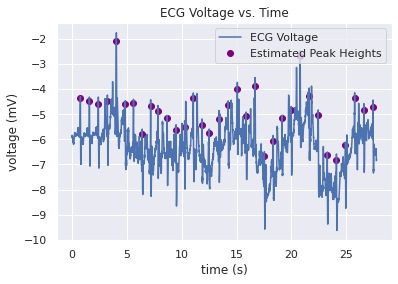

In [246]:
# ============================================================================
# Write your code here
# ============================================================================

plt.figure()
plt.plot(data['time'], data['voltage'])
plt.title('ECG Voltage vs. Time')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')


t_k = data['tk']

peakTimes = []
peakVoltage = []

for peaks in t_k :
  peakTimes.append(data['time'][peaks])
  peakVoltage.append(data['voltage'][peaks])

plt.scatter(peakTimes, peakVoltage, color = 'purple')
plt.legend(['ECG Voltage', 'Estimated Peak Heights'])



#### **Pan-Tompkins Algorithm**
In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

**Task 2B (10 points):** _Bandpass filtering:_ . In this first step we want to eliminate as much as possible interference that is present in our acquired signal. In order to do that we can filter the signal and only leave the frequency range
that is of interest for our task (e.g. $5-15$ Hz as suggested in the original Pan-Tompkins paper) the bandpass filtering operation as the concatenation of a lowpass and a highpass filtering steps:

* _Highpass filtering:_ A highpass filter can be thought of as removing the lower frequency component of the signal. That means that we could use a lowpass filter to get a lowpass version of the original signal and then subtract the result from the original series. We will use a lowpass filter of triangular shape and length $L$. Determine the length of the filter based on the required passband (i.e. the filter should attenuate significantly beyond $5$ Hz) or empirically by adjusting the value of $L$. Plot the original signal together with the lowpass filtered version. The latter one should describe the trend in the ECG recording. Remember to normalize the filters (i.e., weights add up to one) to prevent signal amplification or attenuation. In an additional plot also display the signal with the lowpass version removed (high-pass filtered).

* _Lowpass filtering:_ Use an averaging (box) filter to reduce high-frequency noise. Filter the signal with a filter of length $L=10$ taps.

For your convinence we have provided `boxFilter` and `triangleFilter` functions.

Text(0, 0.5, 'normalized voltage')

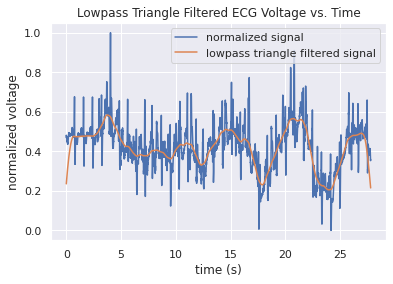

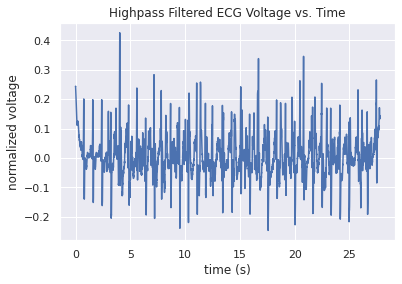

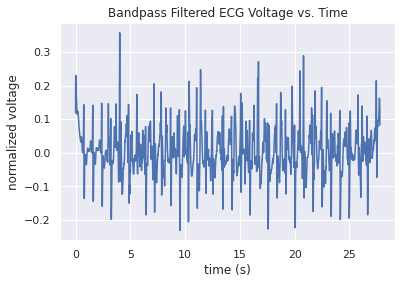

In [248]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)

# ============================================================================
# Write your code here
# ============================================================================

lTri = 500
normVoltage = normalize_range(data['voltage'])
lptFiltered = np.convolve(normVoltage, triangleFilter(lTri), mode = 'same')
plt.figure()
plt.plot(data['time'], normVoltage)
plt.plot(data['time'],lptFiltered)
plt.title('Lowpass Triangle Filtered ECG Voltage vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage')
plt.legend(['normalized signal', 'lowpass triangle filtered signal'])

hpFiltered = normVoltage - lptFiltered
plt.figure()
plt.plot(data['time'], hpFiltered)
plt.title('Highpass Filtered ECG Voltage vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage')


lBox = 10
bpFiltered = np.convolve(hpFiltered, boxFilter(lBox), mode = 'same')
plt.figure()
plt.plot(data['time'], bpFiltered)
plt.title('Bandpass Filtered ECG Voltage vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage')





**Task 2C (10 points):** _Differentiation:_ Differentiate the resulting signal in order to localize the region ofsteepest  slope  in  the  QRS-complex.   You  can  use  the  finite  difference  filter. You can use the finite difference filter: 

$$d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big)$$

Text(0, 0.5, 'normalized voltage/s')

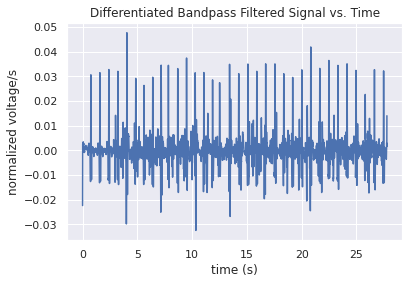

In [249]:
# ============================================================================
# Write your code here
# ============================================================================

Dn = []

for i in range(2, len(bpFiltered) - 2) :
  d = bpFiltered[i - 2] + (2*bpFiltered[i-1]) - (2*bpFiltered[i + 1]) - bpFiltered[i + 2]
  d = d/8
  Dn.append(d)

plt.figure()
plt.plot(np.linspace(min(data['time']), max(data['time']), len(Dn)), Dn)
plt.title('Differentiated Bandpass Filtered Signal vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage/s')






**Task 2D (10 points):** _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform.

Text(0, 0.5, 'normalized (voltage^2)/(s^2)')

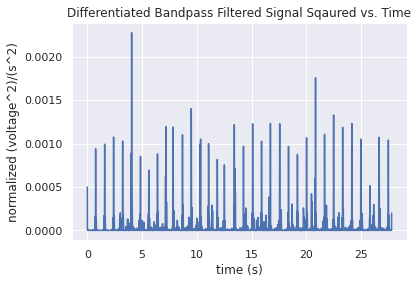

In [250]:
# ============================================================================
# Write your code here
# ============================================================================

DnSquared = []
for entries in Dn :
  DnSquared.append(entries ** 2)

plt.figure()
plt.plot(np.linspace(min(data['time']), max(data['time']), len(DnSquared)), DnSquared)
plt.title('Differentiated Bandpass Filtered Signal Sqaured vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized (voltage^2)/(s^2)')



**Task 2E (10 points):** _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal

Text(0, 0.5, 'normalized voltage')

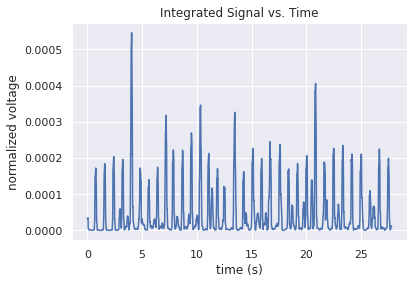

In [251]:
# ============================================================================
# Write your code here
# ============================================================================

integratedSignal = np.convolve(DnSquared, boxFilter(50), mode = 'same')
plt.figure()
plt.plot(np.linspace(min(data['time']), max(data['time']), len(integratedSignal)), integratedSignal)
plt.title('Integrated Signal vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage')


**Task 2F (10 points):** _Peak detection:_ Use a peak detector to estimate the locations of the peaks add them to the previous plot. Estimate the sequence of **RR** intervals and plot the corresponding heart beat rate over time.

Peak at t = 0.7668967587034814 seconds
Peak at t = 1.5838085234093637 seconds
Peak at t = 2.4062775110044017 seconds
Peak at t = 3.2315251100440174 seconds
Peak at t = 4.0484368747499 seconds
Peak at t = 4.857012805122048 seconds
Peak at t = 5.621130952380952 seconds
Peak at t = 6.404699379751901 seconds
Peak at t = 7.17437474989996 seconds
Peak at t = 7.832905662264905 seconds
Peak at t = 8.702611044417766 seconds
Peak at t = 9.494515306122448 seconds
Peak at t = 10.319762905162063 seconds
Peak at t = 11.072766606642658 seconds
Peak at t = 11.878563925570228 seconds
Peak at t = 13.45125800320128 seconds
Peak at t = 14.259833933573429 seconds
Peak at t = 15.104531812725089 seconds
Peak at t = 15.913107743097237 seconds
Peak at t = 16.65221838735494 seconds
Peak at t = 17.569160164065625 seconds
Peak at t = 18.37217887154862 seconds
Peak at t = 19.183533413365343 seconds
Peak at t = 20.017116846738695 seconds
Peak at t = 20.822914165666266 seconds
Peak at t = 21.642604541816723 seconds


Text(0, 0.5, 'heart rate (BPS)')

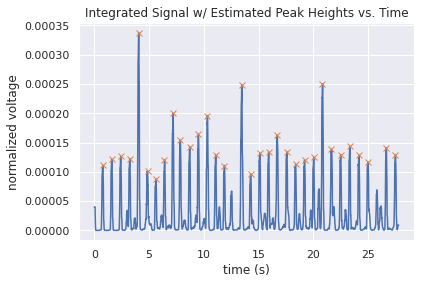

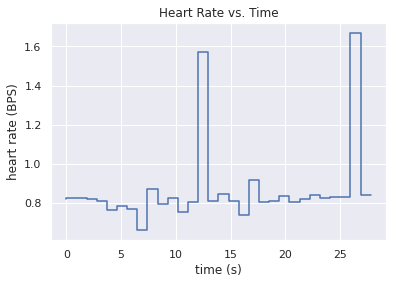

In [239]:
# ============================================================================
# Write your code here
# ============================================================================

thresholdVal = .00008
peaks = signal.find_peaks(integratedSignal, height= thresholdVal, distance = 50)
peaksPlot = peaks[0] * max(data['time'])/len(integratedSignal)

plt.figure()
plt.plot(np.linspace(min(data['time']), max(data['time']), len(integratedSignal)), integratedSignal)
plt.plot(peaksPlot, peaks[1]['peak_heights'], 'x')
plt.title('Integrated Signal w/ Estimated Peak Heights vs. Time')
plt.xlabel('time (s)')
plt.ylabel('normalized voltage')

for times in peaksPlot :
  print("Peak at t =", times, "seconds")

N = len(peaksPlot)
R = 0
heartRate = []

for i in range(1, N) :
  R = R + (peaksPlot[i] - peaksPlot[i - 1])
  heartRate.append(peaksPlot[i] - peaksPlot[i - 1])

R = R / (N - 1)

avgHeartRate = 60 / R

print("The average RR interval is", R, "seconds" )
print("The eastimated heart rate is", avgHeartRate, "beats per minute" )

plt.figure()
plt.step(np.linspace(min(data['time']), max(data['time']), len(heartRate)), heartRate)
plt.title('Heart Rate vs. Time')
plt.xlabel('time (s)')
plt.ylabel('heart rate (BPS)')




